# Stein's Unbiased Risk Estimate

*In this note, I present a derivation of Stein's unbiased risk estimate (SURE), and demonstrate its use in a denoising problem.*

### Derivation of Stein's Unbiased Risk Estimate
Suppose $x$ is a constant and we observe $y = x + n$, where $n$ denotes zero-mean white Gaussian noise, say with variance $\sigma^2$. Now let $\hat{x} = g(y)$ be our estimate of $x$. We would like to estimate
$R = \mathbb{E}\bigl\{|g(y) - x|^2 \bigr\}$. We write
\begin{align}
\mathbb{E}\bigl\{|g(y) - x|^2 \bigr\} &= \mathbb{E}\bigl\{| \bigl( g(y) - y \bigr) + n|^2 \bigr\}\\
& = \mathbb{E}\bigl\{|  g(y) - y |^2 \bigr\} + 2\,\mathbb{E}\bigl\{ \bigl( g(y) - y \bigr)\,n \bigr\} + \sigma^2 \label{eqn:terms}\tag{*}
\end{align}
Here, the last term is the variance of $n$. Also, observe that the first term involves only the observed value $y$. In practice, if we have many independent observations $y_i = x + n_i$, where $n_i$'s are iid Gaussian, we can get a reasonable approximation of this term through
\begin{equation}
\frac{1}{N} \, \sum_{i = 1}^N \bigl| g(y_i) - y_i \bigr|^2,
\end{equation}
thanks to the law of large numbers.

Let us now consider the second term in \eqref{eqn:terms}.
\begin{align}
\mathbb{E}\bigl\{ \bigl( g(y) - y \bigr)\,n \bigr\} &= \int_{-\infty}^{\infty} \underbrace{ \bigl( g(x + t ) - (x+t) \bigr)}_{f_1(t)}\,\,\underbrace{ t\,\frac{1}{\sqrt{2\pi}\sigma}e^{-t^2/2\sigma^2}}_{f_2'(t)}\,dt \\
&=  - \int_{-\infty}^{\infty} \underbrace{ \bigl( g'(x + t ) - 1 \bigr)}_{f_1'(t)} \underbrace{ \frac{-\sigma^2}{\sqrt{2\pi}\sigma}e^{-t^2/2\sigma^2}}_{f_2(t)}\,dt\\
&= \sigma^2\,\mathbb{E}\bigl\{ g'(x+n) \bigr\} - \sigma^2\\
&= \sigma^2\,\mathbb{E}\bigl\{ g'(y) \bigr\} - \sigma^2.
\end{align}

Notice that this derivation depends heavily on the form of the Gaussian pdf. We can now estimate $\mathbb{E}\bigl\{|g(y) - x|^2 \bigr\}$ as,
\begin{equation}
\hat{R} =  \frac{1}{N}  \sum_{i = 1}^N \,  \bigl| g(y_i) - y_i \bigr|^2 + 2\,\sigma^2\,g'(y_i) - \sigma^2.
\end{equation}

### SURE for Soft Thresholding
Suppose now that we have observations $y_i = x_i + n_i$, for $i = 1,\ldots,N$. Also, let
\begin{equation}
g_{\tau}(y) = \text{sign}(y)\,\max\bigl( |y| -  \tau, 0\bigr).
\end{equation}
In this case, observe that
\begin{equation}
|g(y) - y|^2 + 2\sigma^2\,g'(y) = \begin{cases}
|y|^2, \quad &\text{if } |y| < \tau,\\
\tau^2 + 2\sigma^2, &\text{if } |y| > \tau.
\end{cases}
\end{equation}

In the following, I demonstrate the computation of SURE, and show how it can be used to select the threshold used in the soft-threshold denoiser. 

Let us first create the signal and the noisy observations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

K = 10000 # length of the signal
sig = 0.1 # std of noise
x = 10 * (np.random.uniform(-1,1,K) ** 3)
y = x + np.random.normal(0,sig,K)

Declare the denoising operator to be the soft-threshold function.

In [2]:
soft = lambda x, t : np.sign(x) * np.maximum(np.abs(x) - t, 0)

Define now the functions for computing the actual MSE and SURE.

In [3]:
TrueMSE = lambda x, y : np.sum((x - y)**2)

SureSoftMSE = lambda y, t, sig : ( np.sum(y[np.abs(y) < t]**2) 
    + np.sum(np.abs(y) > t) * (t**2 + 2 * sig**2) - sig**2 * y.size )

Now, set the threshold to $\sigma$ and obtain the denoised estimate $z$. Given $z$, we can compute the true RMSE, if we *knew* the clean $x$. SURE estimates this RMSE without knowledge of $x$. We compare SURE to the true value of the RMSE.

In [4]:
t = sig
z = soft(y,t)

trueMSE = TrueMSE(z,x)
Sure = SureSoftMSE(y,t,sig)

print('True MSE : {:.3f}, SURE : {:.3f}'.format(trueMSE, Sure))

True MSE : 154.927, SURE : 157.239


By computing SURE for all values of the threshold, we can obtain an MSE curve. Below, we compare that curve to the true MSE.

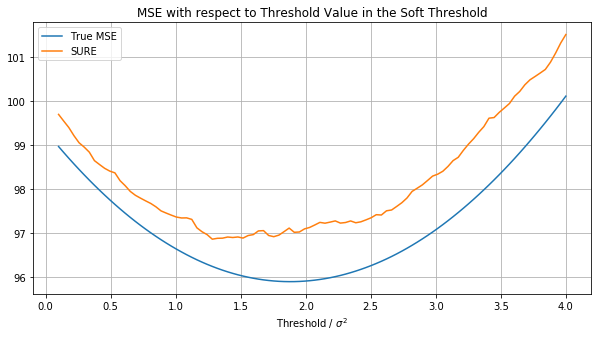

In [5]:
thold = np.linspace(0.1, 4, 100) * sig**2
MSEcurve = np.zeros(thold.size)
SUREcurve = np.zeros(thold.size)

for ind, t  in enumerate(thold):
    z = soft(y,t)
    MSEcurve[ind] = TrueMSE(z,x)
    SUREcurve[ind] = SureSoftMSE(y,t,sig)

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(thold/sig**2, MSEcurve, label = 'True MSE')
ax.plot(thold / sig**2, SUREcurve, label = 'SURE')
ax.legend()
ax.set_xlabel(r'Threshold / $\sigma^2$')
ax.set_title('MSE with respect to Threshold Value in the Soft Threshold')
ax.grid()

Notice that the two curves are fairly similar. This allows to set the value of the threshold so as to minimize the MSE, as if we have access to an oracle.

*Ilker Bayram, ibayram@ieee.org*